##Multi-task learning-Implementing age estimation and gender classification

Multi-task learning is a branch of research where a single/few inputs are used to predict several different but utimately connected outputs. For example, in a self-driving car, the model needs to identify obstalces, plan routes, give the right amount of throttle/brake and steering, to name but a few. It needs to do all these in a split second by considering the same set of inputs (which would come from several factors)

From the various use cases we have solved so far, we are in a position to train a neural network and estimate the age of a person given an image or predict the gender of the person given an image, separately, one task at a time.

However, we have not looked at a scenario where we will be able to predict both age and gender in a single shot from an image. Predictinf two different attributes in a single shot is important, as the same image is used for both predictions .

Here, we'll learn about predicting both attributes, continous and categorical predictions, in a single forward pass.

The stragegy we will adopt is as follows:

1. Import the relevant packages

2. Fetch a dataset that contains images of persons, their gender, and age information

3. Create training and test datasets by  performing appropriate pre-processing.

4. Build a model where the following applies:
  * All the layers of the model remain similar to the models we have built so far, except for the last part.

  * In the last part, create two separate layers branching out from the preceding layer, where one layer corresponds to age estimation and the other to gender classification.

  * Ensure that you have different loss functions for each branch of the output, as age is a constinous value (requiring an mse or mae loss calculation) and gender is a categorical value (requiring a cross-entropy loss calculation).

  * Take a weighted summation of age estimation loss and gender classification loss.

  * Minimize the overall loss by performing backpropagation that optimizes weight values.

5. Train the model and predict on new images.  

##1. Import the relevant packages

In [3]:
# 1. Import the relevant packages
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'


##2. Fetch the dataset

In [4]:
# Fetch the dataset
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getFile_from_drive(file_id, name):
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)


getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

!unzip -qq fairface-img-margin025-trainval.zip

##3. The dataset we downloaded can be loaded and is structured in the following way

In [5]:
# 3. The dataset we downloaded can be loaded and is structured in the following way
trn_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [6]:
val_df.head()

,file,age,gender,race,service_test
0,val/1.jpg,11,Male,East Asian,False
1,val/2.jpg,51,Female,East Asian,True
2,val/3.jpg,37,Male,White,True
3,val/4.jpg,25,Female,Latino_Hispanic,True
4,val/5.jpg,24,Male,Southeast Asian,False


## 4. Build the GenderAgeClass that takes a filename as input and returns the corresponding image, gender, and scaled age.

We scale the age as it is a continous number and, as we have seen in chapter 3, it is better to scale data to avoid vanishing gradients and rescale it during post-processing

In [7]:
from torch.utils.data import Dataset, DataLoader
import cv2
IMAGE_SIZE = 224

class GenderAgeClass(Dataset):
  # Provide file paths of images in the init method
  def __init__(self, df, tfms=None):
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

  # Method that returns the number of images in the input
  def __len__(self): return len(self.df)

  # Method that fetches information of an image at a given position, ix
  def __getitem__(self, ix):
    f = self.df.iloc[ix].squeeze()
    file = f.file
    gen = f.gender == 'Female'
    age = f.age
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im, age, gen

  # Method for pre-processing an image i.e resizing, permuting the channels
  # and performing normalization on scaled image
  def preprocess_image(self, im):
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    im = torch.tensor(im).permute(2,0,1)
    im = self.normalize(im/255.)
    return im[None]

  # Method which fetches a batch of data where the data points are pre-processed
  def collate_fn(self, batch):
    'preprocess images, ages and genders'
    ims, ages, genders = [], [], []
    for im, age, gender in batch:
      # 1.Process each image using the process_image method
      im = self.preprocess_image(im)
      ims.append(im)

      # 2.Scale the age by 80 (maximum age value present in the dataset), so that
      #all values are between 0 and 1
      ages.append(float(int(age)/80))

      # 3.Convert gender to a float value
      genders.append(float(gender))


    # 4. Image,age and gender are each converted into torch objects and returned
    ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]

    ims = torch.cat(ims).to(device)

    return ims, ages, genders

##5. Now define the training and validation datasets and data loaders

In [8]:
# Now we define the training and validation datasets and data loaders

# Create the datasets
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

# Specify the data loaders
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(trn, batch_size=32, shuffle=True,
                          drop_last=True, collate_fn=trn.collate_fn)

test_loader = DataLoader(val, batch_size=32,
                         collate_fn=val.collate_fn)

a,b,c = next(iter(train_loader))
print(a.shape, b.shape, c.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


##6. Define the model, loss function and optimizer

In [9]:
# 6. Define the model, loss function and optimizer

def get_model():
  # Load the pretrained VGG16 model
  weights = models.VGG16_Weights.DEFAULT
  model = models.vgg16(weights=weights)

  # freeze the laoded model
  for param in model.parameters():
    param.requires_grad = False

  # Overwrite the avgpool layer with our own layer
  model.avgpool = nn.Sequential(
    nn.Conv2d(512, 512, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten()
  )

  # Build a neural network class named ageGenderClassifier
  class ageGenderClassifier(nn.Module):
    def __init__(self):
      super(ageGenderClassifier, self).__init__()
      # Define the intermediate layer calculations
      self.intermediate = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 64),
        nn.ReLU()
      )

      # Define age_classifier and gender_classifier
      self.age_classifier = nn.Sequential(
        nn.Linear(64, 1),
        nn.Sigmoid()
      )

      self.gender_classifier = nn.Sequential(
        nn.Linear(64, 1),
        nn.Sigmoid()
      )
      'Note that, in the preceding code, the last layers have a sigmoid \
      activation since the age output will be a value between 0 and 1 \
      (as it is scaled by 80) and gender has a sigmoid as the output is \
      either a 0 or 1. '

      # Define the forward pass method that stacks layers as intermediate first,
      # followed by age_classifier and then gender_classifier

    def forward(self, x):
      x = self.intermediate(x)
      age = self.age_classifier(x)
      gender = self.age_classifier(x)
      return gender, age

  # Overwrite the classifier module with the class defined
  model.classifier = ageGenderClassifier()

  # Define the loss functions for both the gender(BCE) and age(L1) plus the optimizer
  gender_loss_fn = nn.BCELoss()
  age_loss_fn = nn.L1Loss()
  loss_functions = gender_loss_fn, age_loss_fn
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  return model.to(device), loss_functions, optimizer

In [10]:
# Call  the get_model function to initialize the values int the variables
model, loss_functions, optimizer = get_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 92.6MB/s]


In [11]:
!pip install torchinfo
from torchinfo import summary
summary(model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size","num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   (73,856)             False
│    └─ReLU (6)                          [32, 128, 112, 112]  --                   --
│    └─Conv2d (7)                        [32, 128, 112, 112]  (147,584)            False
│    └─ReLU (8)            

In [12]:
# Using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

##7. Define a function to train on a batch of data and validate on a batch of the dataset

In [13]:
# 7. Define a function to train on a batch of data and validate on a batch of
# the dataset

# train on a batch of data
def train_batch(data, model, optimizer, loss_fn):
  model.train()
  ims, age, gender = data
  pred_gender, pred_age = model(ims)

  # Fetch loss functions for both age and gender before calculating the losses
  gender_loss_fn, age_loss_fn = loss_fn
  gender_loss = gender_loss_fn(pred_gender.squeeze(), gender)
  age_loss = age_loss_fn(pred_age.squeeze(), age)

  optimizer.zero_grad()
  # Calculate the overall loss by summing them up
  total_loss = gender_loss + age_loss

  # Perform backprogation to reduce overall loss
  total_loss.backward()

  # Step the optimizer
  optimizer.step()

  # return the overall loss
  return total_loss


# Validatin function
def validate_batch(data, model, loss_fn):
  model.eval()
  img, age, gender = data
  with torch.inference_mode():
    pred_gender, pred_age = model(img)

  # Calculate the loss values corresponding to age and gender predictions
  gender_loss_fn, age_loss_fn = loss_fn
  gender_loss = gender_loss_fn(pred_gender.squeeze(), gender)
  age_loss = age_loss_fn(pred_age.squeeze(), age)

  #Calculate the overall loss
  total_loss = gender_loss + age_loss

  # Calculate the final predicted gender class
  pred_gender = (pred_gender > 0.5).squeeze()
  gender_acc = (pred_gender == gender).float().sum()

  age_mae = torch.abs(age - pred_age).float().sum()

  return total_loss, gender_acc, age_mae


In [14]:
len(train_loader)

2710

##8. Train the model over five epochs

In [15]:
#8. Train the model over five epochs

# Define place holders to store the train and test loss values and also
# to specify the number of epochs

import time
model, loss_functions, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 5
best_test_loss = 1000
start = time.time()

# Loop through different epochs and reinitialize the train and test loss
# values at the start of every epoch
for epoch in range(n_epochs):
  epoch_train_loss, epoch_test_loss = 0, 0
  val_age_mae, val_gender_acc, ctr = 0, 0, 0
  _n = len(train_loader)

  # Loop through the training data loader and train the model
  print("[INFO]====> TRAINIG")
  for ix, data in enumerate(train_loader):
    if ix % 200 == 0: print(f"Looked at: {ix} data samples already.")
    #if ix == 100: break
    loss = train_batch(data, model, optimizer, loss_functions)
    epoch_train_loss += loss.item()

  # Loop through the  test data loader and calculate gender accuracy as well
  # as the mae of age
  print("[INFO] ====> TESTING")
  for ix, data in enumerate (test_loader):
    if ix % 200 == 0: print(f"Looked at: {ix} data samples already.")
    #if ix == 100: break
    loss, gender_acc, age_mae = validate_batch(data, model, loss_functions)
    epoch_test_loss += loss.item()
    val_age_mae += age_mae
    val_gender_acc += gender_acc
    ctr += len(data[0])

  # Calculate the overall accuracy of age prediction and gender classification
  val_age_mae /= ctr
  val_gender_acc /= ctr
  epoch_train_loss /= len(train_loader)
  epoch_test_loss /= len(test_loader)

  # Log the metrics for each epoch
  elasped = time.time() - start
  best_test_loss = min(best_test_loss, epoch_test_loss)
  print('{}/{}({:.2f}s - {:.2f}s remaining)'.format(\
    epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elasped/(epoch+1)))
  )

  info = f"""Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\Test: \
           {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}"""

  info += f"\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n"

  print(info)

  val_gender_accuracies.append(val_gender_acc)
  val_age_maes.append(val_age_mae)


[INFO]====> TRAINIG
Looked at: 0 data samples already.
Looked at: 200 data samples already.
Looked at: 400 data samples already.
Looked at: 600 data samples already.
Looked at: 800 data samples already.
Looked at: 1000 data samples already.
Looked at: 1200 data samples already.
Looked at: 1400 data samples already.
Looked at: 1600 data samples already.
Looked at: 1800 data samples already.
Looked at: 2000 data samples already.
Looked at: 2200 data samples already.
Looked at: 2400 data samples already.
Looked at: 2600 data samples already.
[INFO] ====> TESTING
Looked at: 0 data samples already.
Looked at: 200 data samples already.
1/5(740.59s - 3702.97s remaining)
Epoch: 001	Train Loss: 0.749\Test:            0.715	Best Test Loss: 0.7154
Gender Accuracy: 81.24%	Age MAE: 8.63

[INFO]====> TRAINIG
Looked at: 0 data samples already.
Looked at: 200 data samples already.
Looked at: 400 data samples already.
Looked at: 600 data samples already.
Looked at: 800 data samples already.
Looked at: 

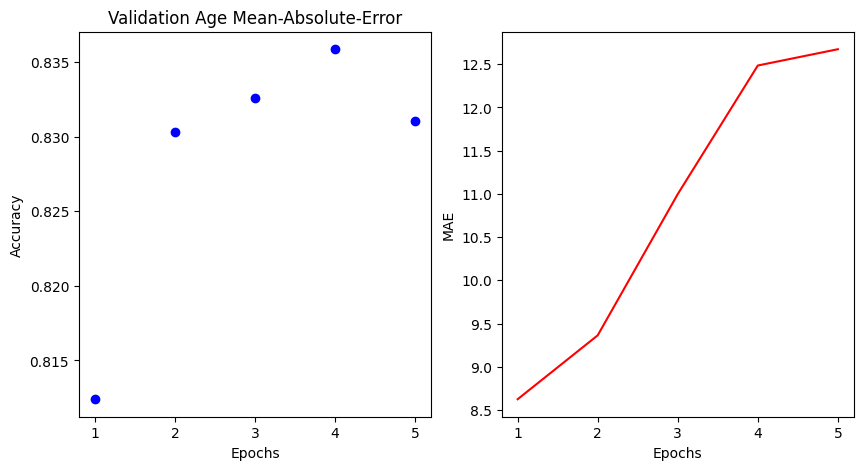

In [37]:
epochs = np.arange(1,len(val_gender_accuracies)+1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs, [v.item() for v in val_gender_accuracies], 'bo')
ax[1].plot(epochs, [v.item() for v in val_age_maes], 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()


In [40]:
im = cv2.imread('/content/val/10110.jpg')
im = cv2.resize(im, (224, 224))
im = trn.preprocess_image(im).to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
im = cv2.imread('/content/val/10110.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

##Using the torch_snippets library

In [16]:
# 1. Install and load the library
!pip install torch_snippets
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.8 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26302 sha256=1

In [41]:
# 2. Download the data and create a dataset
IMAGE_SIZE = 24
class GenderAgeClass(Dataset):
  def __init__(self, df, tfms=None):
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

  def __len__(self): return len(self.df)

  def __getitem__(self, ix):
    f = self.df.iloc[ix]  .squeeze()
    file = f.file
    gen = f.gender == 'Female'
    age = f.age
    im = read(file, 1)
    return im, age, gen

  def preprocess_image(self, im):
    im = resize(im, IMAGE_SIZE)
    im = torch.tensor(im).permute(2, 0, 1)
    im = self.normalize(im/255.)
    return im[None]

  def collate_fn(self, batch):
    'preprocess images, ages and genders'
    ims, ages, genders = [], [], []
    for im, age,gender in batch:
      im = self.preprocess_image(im)
      ims.append(im)

      ages.append(float(int(age)/80))
      genders.append(float(gender))

    ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
    ims = torch.cat(ims).to(device)

    return ims, ages, genders

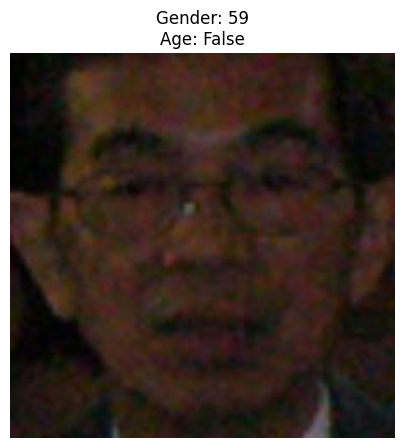

In [18]:
# 3. Specify the training and validation datasets and view the sample images
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)
train_dataloader = DataLoader(trn, batch_size=32, shuffle=True,
                              drop_last=True, collate_fn=trn.collate_fn)

test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

im, gen, age = trn[0]
show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)



In [19]:
help(show)

Help on function show in module torch_snippets.loader:

show(img=None, ax=None, title=None, sz=None, bbs=None, confs=None, texts=None, bb_colors=None, cmap='gray', grid: bool = False, save_path: str = None, text_sz: int = None, df: pandas.core.frame.DataFrame = None, pts=None, conns=None, interactive: bool = False, jitter: int = None, frame_count: int = 1, **kwargs)
    show an image



In [34]:
import torch
from torch_snippets.inspector import inspect
help(inspect)

Help on function inspect in module torch_snippets.inspector:

inspect(*arrays, **kwargs)
    shows shape, min, max and mean of an array/list/dict of oreys
    Usage:
    inspect(arr1, arr2, arr3, [arr4,arr5,arr6], arr7, [arr8, arr9],...)
    where every `arr` is  assume to have a .shape, .min, .max and .mean methods



In [35]:
# 4. Create data loaders and inspect the tensors
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

ims, gens, ages = next(iter(train_loader))
inspect(ims, gens, ages)

══════════════════════════════════════════════════════════════════


NameError: name 'torch' is not defined

In [36]:
# 5. Create model, optimizer, loss_functions, train_batch and validate_batch
from torchvision import models
def get_model():
  weights = models.VGG16_Weights.DEFAULT
  model = models.vgg16(weights=weights)

  # Freeze parameters so we don't backprop through them
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential(
    nn.Conv2d(512, 512, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten()
  )

  class ageGenderClassifier(nn.Module):
    def __init__(self):
      super(ageGenderClassifier, self).__init__()
      self.intermediate = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 64),
        nn.ReLU()
      )

      self.age_classifier = nn.Sequential(
        nn.Linear(64, 1),
        nn.Sigmoid()
      )

      self.gender_classifier = nn.Sequential(
        nn.Linear(64, 1),
        nn.Sigmoid()
      )

    def forward(self, x):
      x = self.intermediate(x)
      age = self.age_classifier(x)
      gender = self.gender_classifier(x)
      return gender, age


  model.classifier = ageGenderClassifier()

  gender_criterion = nn.BCELoss()
  age_criterion = nn.L1Loss()
  loss_functions = gender_criterion, age_criterion
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  return model.to(device), loss_functions, optimizer


model, loss_functions, optimizer = get_model()

In [30]:
model


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
from torchsummary import summary
summary(model, input_size=(3,224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [28]:
def train_batch(data, model, optimizer, criteria):
  model.train()
  ims, age, gender = data
  optimizer.zero_grad()
  pred_gender, pred_age = model(ims)
  gender_criterion, age_criterion = criteria
  gender_loss = gender_criterion(pred_gender.squeeze(), gender)
  age_loss = age_criterion(pred_age.squeeze(), age)
  total_loss = gender_loss + age_loss
  total_loss.backward()
  optimizer.step()
  return total_loss

def validate_batch(data, model, criteria):
  model.eval()
  ims, age, gender = data
  with torch.inference_mode():
    pred_gender, pred_age = model(ims)

  gender_criterion, age_criterion = criteria
  gender_loss = gender_criterion(pred_gender.squeeze(), gender)
  age_loss = age_criterion(pred_age.squeeze(), age)
  total_loss = gender_loss + age_loss
  pred_gender = (pred_gender > 0.5).squeeze()
  gender_acc = (pred_gender == gender).float().sum()
  age_mae = torch.abs(age - pred_age).float().sum()
  return total_loss, gender_acc, age_mae

In [26]:
from torch_snippets import *
from torch_snippets.torch_loader import Report

In [27]:
# 6. Finally, we need to load all the components and start training.
# Log the metrics over increasing epochs
model, criterion, optimizer = get_model()

n_epochs = 5
log = Report(n_epochs)